In [1]:
using PyPlot, StatsBase, Printf, DelimitedFiles;
using Revise;
using MDToolbox;
PyPlot.plt.style.use("seaborn-colorblind");
ENV["COLUMNS"] = 110; #display width for MDToolbox

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /Users/yasu/.julia/packages/Revise/moD4B/src/packagedef.jl:1361


### Potential energy function its gradients

In [2]:
V(x; k=1.0) = sum(- (1.0 / 2.0) .* k .* x.^2 .+ (1.0 ./ 4.0) .* k .* x.^4)
#V(x; k=1.0) = sum((1.0 .- x.^2).^2 .- 0.25 .* x)
V([0.0])

0.0

In [3]:
grad(x; k= 1.0) =  - k .* x .+ k .* x.^3
#grad(x; k=1.0) = -2.0.*(1.0 .- x.^2).*2.0.*x .- 0.25

grad (generic function with 1 method)

### Replica MD with exchange

In [4]:
function exchange_temperature!(m2i, i2m, icount, x_replica, pot_fun::Function, temperature_replica)
    nreplica = length(x_replica)

    m_array = 1:nreplica
    t_array = temperature_replica[m_array]
    b_array = 1.0 ./ t_array
    i_array = m2i[m_array]
    v_array = map(pot_fun, x_replica[i_array])
    
    if mod(icount, 2) == 0
        m_lower = 1:2:(nreplica-1)
        m_higher = 2:2:nreplica
    else
        m_lower = 2:2:(nreplica-1)
        m_higher = 3:2:nreplica
    end
    
    iaccepted = 0
    for ipair = 1:length(m_higher)
        m1 = m_lower[ipair]
        m2 = m_higher[ipair]
        delta = (b_array[m2] - b_array[m1]) * (v_array[m1] - v_array[m2])
        if exp(-delta) > rand()
            m2i[m_array[m1]], m2i[m_array[m2]] = m2i[m_array[m2]], m2i[m_array[m1]]
            i2m[i_array[m1]], i2m[i_array[m2]] = i2m[i_array[m2]], i2m[i_array[m1]]
            iaccepted += 1
        end
    end

    return iaccepted / length(m_higher)
end

exchange_temperature! (generic function with 1 method)

In [5]:
nreplica = 4
temperature_replica = [0.01, 0.10, 0.30, 0.40];
#temperature_replica = [0.04, 1.25];
nstep = 1000;
nexchange = 100;
m2i = collect(1:nreplica)
i2m = collect(1:nreplica)

x_replica = []
for i = 1:nreplica
    x = [-1.0]
    push!(x_replica, x)
end

io_replica = []
for i = 1:nreplica
    filename = "replica$(i).dat"
    io = open(filename, "w")
    push!(io_replica, io)
end

icount = 0
acceptance_ratio = 0.0
for iexchange = 1:nexchange
    for i = 1:nreplica
        x_replica[i] = propagate_md(grad, x_replica[i], temperature_replica[i2m[i]], nstep=nstep, io=io_replica[i]);
    end
    # do exchange
    acceptance_ratio += exchange_temperature!(m2i, i2m, icount, x_replica, y -> V(y, k=1.0), temperature_replica)
    icount += 1
end

for i = 1:nreplica
    close(io_replica[i])
end

acceptance_ratio = acceptance_ratio / nexchange

0.675

### Trajectory analysis

In [6]:
traj_replica = []
temp_replica = []

for i = 1:nreplica
    filename = "replica$(i).dat"
    data = readdlm(filename);
    push!(temp_replica, data[:, 1])
    push!(traj_replica, data[:, 2])
end

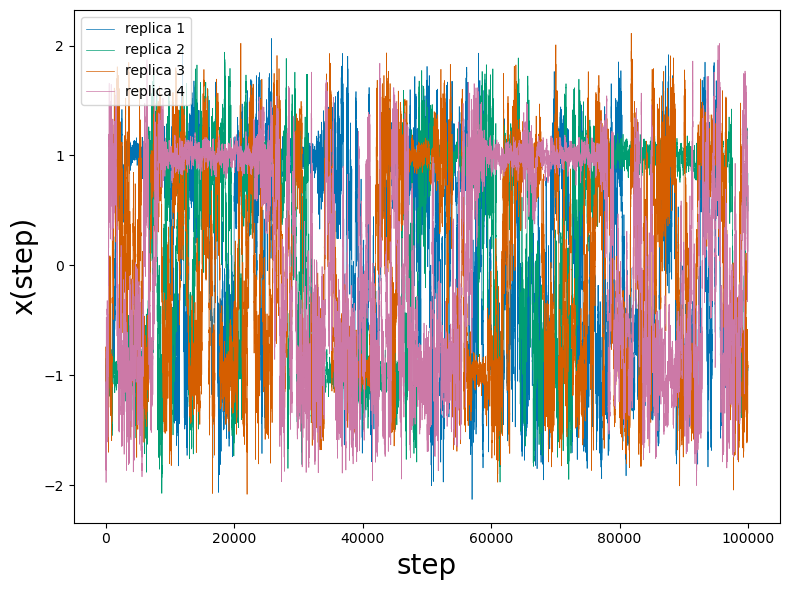

In [7]:
fig, ax = subplots(figsize=(8, 6))
for i = 1:nreplica
    ax.plot(traj_replica[i], linewidth=0.5)   
end
xlabel("step",fontsize=20)
ylabel("x(step)",fontsize=20)

ax.legend(["replica 1", "replica 2", "replica 3", "replica 4"])
tight_layout()

In [8]:
# sort trajectories according to temperature
function sort_traj(traj_replica, temp_replica)
    traj_sorted = deepcopy(traj_replica)
    temp_sorted = deepcopy(temp_replica)
    nframe = size(traj_replica[1], 1)
    for iframe = 1:nframe
        temp_snapshot = map(x -> x[iframe], temp_replica)
        p = sortperm(temp_snapshot)
        for m = 1:nreplica
            traj_sorted[m][iframe, :] .= traj_replica[p[m]][iframe, :]
            temp_sorted[m][iframe, :] .= temp_replica[p[m]][iframe, :]
        end
    end
    return traj_sorted, temp_sorted
end

sort_traj (generic function with 1 method)

In [9]:
traj_sorted, temp_sorted = sort_traj(traj_replica, temp_replica)

(Any[[-0.995322, -0.989315, -0.955822, -0.940127, -0.944632, -0.944024, -0.970804, -0.960872, -0.950144, -0.93449  …  -0.963984, -0.965827, -0.934884, -0.926676, -0.945493, -0.942878, -0.944225, -0.946337, -0.951861, -0.95598], [-1.020135, -1.054832, -1.110934, -1.180371, -1.137365, -1.109062, -1.044301, -1.143495, -1.12669, -1.125987  …  0.539169, 0.510147, 0.535487, 0.507511, 0.549253, 0.539092, 0.492692, 0.543787, 0.541163, 0.572252], [-1.061586, -0.982564, -1.05483, -0.956958, -0.852406, -0.908683, -0.893745, -0.946282, -0.815496, -0.740585  …  -0.912315, -1.04098, -1.131348, -1.005696, -1.061806, -1.063537, -1.06984, -0.933159, -0.909587, -0.915458], [-1.060047, -1.094612, -1.184321, -1.371761, -1.389783, -1.300401, -1.286083, -1.30917, -1.445281, -1.33914  …  0.18051, 0.30485, 0.169831, 0.34682, 0.434451, 0.538578, 0.598064, 0.617559, 0.710904, 0.72771]], Any[[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01  …  0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01

In [10]:
temp_sorted[1]

100000-element Array{Float64,1}:
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 ⋮
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01

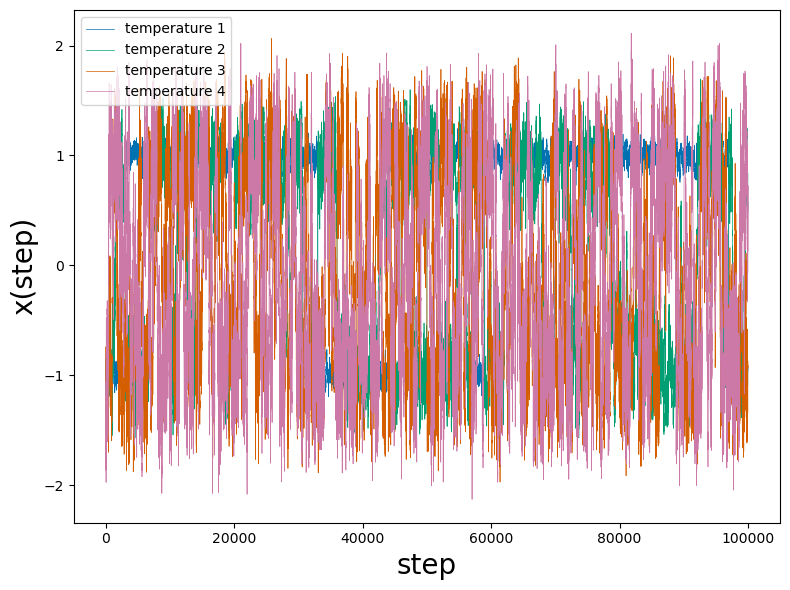

In [11]:
fig, ax = subplots(figsize=(8, 6))
for i = 1:nreplica
    ax.plot(traj_sorted[i], linewidth=0.5)   
end
xlabel("step",fontsize=20)
ylabel("x(step)",fontsize=20)

ax.legend(["temperature 1", "temperature 2", "temperature 3", "temperature 4"])
tight_layout()

In [15]:
#x_grid = range(-1.3, 1.3, length=100);
x_grid = collect(-1.3:0.1:1.3)
pmf_theory = V.(x_grid, k=1) ./ temperature_replica[1]
pmf_theory .= pmf_theory .- minimum(pmf_theory);

In [16]:
pmf_observed, _ = compute_pmf(traj_sorted[1], grid_x = collect(x_grid), bandwidth=0.05);

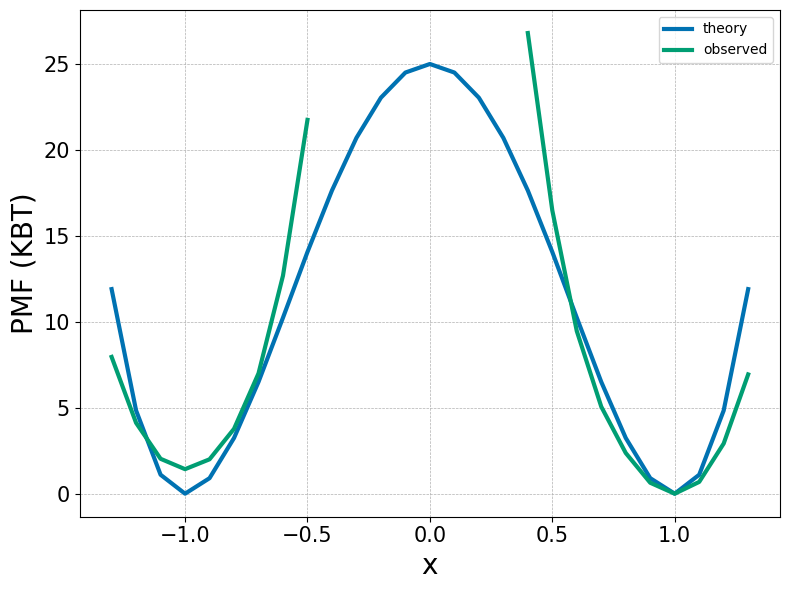

In [17]:
fig, ax = subplots(figsize=(8, 6))
ax.plot(x_grid, pmf_theory, linewidth=3)
xlabel("x",fontsize=20)
ylabel("PMF (KBT)",fontsize=20)

ax.plot(x_grid, pmf_observed, linewidth=3)

ax.legend(["theory", "observed"])

ax.xaxis.set_tick_params(which="major",labelsize=15)
ax.yaxis.set_tick_params(which="major",labelsize=15)
ax.grid(linestyle="--", linewidth=0.5)
tight_layout()
savefig("md_replica_exchange.png", dpi=350)

In [21]:
x_grid[4], x_grid[24]

(-1.0, 1.0)

In [22]:
abs(pmf_observed[4] - pmf_observed[24])

1.4264075679842043